# All vs All

In [1]:
import pickle

import numpy as np

import pandas as pd

% matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set()

import joblib

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler

from libs.container import Container
from libs.display import d
from libs.nearest import nearest
from libs.experiment import KFoldExperiment, WithAnotherExperiment, roc, metrics
from libs.precstar import  prec_star

In [2]:
sample = pd.read_pickle("data/o3o4vZ/scaled/s2_5k.pkl.bz2")
sample["tile"] = sample["id"].apply(lambda i: "b" + str(i)[1:4])
sample["cls"] = sample.vs_type.apply(lambda x: 0 if x == "" else 1)

no_features = ["id", "vs_catalog", "vs_type", "ra_k", "dec_k", "tile", "cls"] 
X_columns = [c for c in sample.columns if c not in no_features]

grouped = sample.groupby("tile")
data = Container({k: grouped.get_group(k).copy() for k in grouped.groups.keys()})

del grouped, sample

In [3]:
# for k in data.keys(): 
#     if k not in ("b278", "b261"):
#         del data[k]
# data

## Features

In [4]:
results = {}
cpu = joblib.cpu_count()

In [5]:
cls = {0:0, 1:1}

In [6]:
d(X_columns)

1. Amplitude
2. AmplitudeH
3. AmplitudeJ
4. AmplitudeJH
5. AmplitudeJK
6. Autocor_length
7. Beyond1Std
8. CAR_mean
9. CAR_sigma
10. CAR_tau
11. Con
12. Eta_e
13. FluxPercentileRatioMid20
14. FluxPercentileRatioMid35
15. FluxPercentileRatioMid50
16. FluxPercentileRatioMid65
17. FluxPercentileRatioMid80
18. Freq1_harmonics_amplitude_0
19. Freq1_harmonics_amplitude_1
20. Freq1_harmonics_amplitude_2
21. Freq1_harmonics_amplitude_3
22. Freq1_harmonics_rel_phase_0
23. Freq1_harmonics_rel_phase_1
24. Freq1_harmonics_rel_phase_2
25. Freq1_harmonics_rel_phase_3
26. LinearTrend
27. MaxSlope
28. Mean
29. Meanvariance
30. MedianAbsDev
31. MedianBRP
32. PairSlopeTrend
33. PercentAmplitude
34. PercentDifferenceFluxPercentile
35. PeriodLS
36. Period_fit
37. Psi_CS
38. Psi_eta
39. Q31
40. Rcs
41. Skew
42. SmallKurtosis
43. Std
44. c89_c3
45. c89_hk_color
46. c89_jh_color
47. c89_jk_color
48. c89_m2
49. c89_m4
50. cnt
51. n09_c3
52. n09_hk_color
53. n09_jh_color
54. n09_jk_color
55. n09_m2
56. n09_m4
57. ppmb

In [7]:
SIZES = {
    'b220': 211850,
    'b234': 297302,
    'b247': 414497,
    'b248': 426369,
    'b261': 575075,
    'b262': 591770,
    'b263': 585661,
    'b264': 614967,
    'b277': 753146,
    'b278': 781612,
    'b396': 494646}

SP = .1

def get_prec_star(r, tile_name):
    rs = SIZES[tile_name]
    return prec_star(r.y_test, r.probabilities[:,1], r.test_size, rs)


def argmax_lt_1(arr):
    arr = np.copy(arr)
    arr[arr >= 1] = - 9999
    return np.argmax(arr)


def get_metrics(kf, vss, train_name):
    # kfold correction
    
    pstar = get_prec_star(kf, train_name)
    idx = argmax_lt_1(pstar)
        
    precs, recs, curve = kf.prec_rec_curve
    kfold_prec = pstar[idx]
    kfold_recall = recs[idx]
    
    m = Container(
        kfold=(kfold_prec, kfold_recall), vss=Container())
    
    for vs in vss:
        pstar = get_prec_star(vs, vs.test_name)
        idx = argmax_lt_1(pstar)
        
        precs, recs, curve = vs.prec_rec_curve
        prec = pstar[idx]
        recall = recs[idx]
        m.vss[vs.test_name] = (prec, recall)
    
    return m


def run(train, data):
    print ">>>> Kfolding {} <<<<".format(train)
    kf = KFoldExperiment(
        clf=RandomForestClassifier(n_estimators=500, criterion="entropy", n_jobs=cpu), clsnum=cls, 
        data=data, pcls=1, ncls=0, X_columns=X_columns, y_column="cls", verbose=False)
    kf = kf(train, nfolds=10)
    
    print ">>>> Vs {}<<<<".format(train)
    vs = WithAnotherExperiment(
        clf=RandomForestClassifier(n_estimators=500, criterion="entropy"), verbose=False, 
        clsnum=cls, data=data, pcls=1, ncls=0, X_columns=X_columns, y_column="cls")
    vs = vs(train)
    
    return train, {"metrics": get_metrics(kf=kf, vss=vs, train_name=train), "kf": kf, "vs": vs}

In [8]:
with joblib.Parallel(n_jobs=cpu) as jobs:
    result = jobs(
        joblib.delayed(run)(k, data)
        for k in sorted(data.keys()))
results["small"] = dict(result)

>>>> Kfolding b220 <<<<
>>>> Kfolding b234 <<<<
>>>> Kfolding b247 <<<<
>>>> Kfolding b248 <<<<
>>>> Kfolding b261 <<<<
>>>> Kfolding b262 <<<<
>>>> Kfolding b263 <<<<
>>>> Kfolding b264 <<<<
>>>> Kfolding b277 <<<<
>>>> Kfolding b278 <<<<
>>>> Kfolding b396 <<<<
>>>> Vs b220<<<<
>>>> Vs b234<<<<
>>>> Vs b247<<<<
>>>> Vs b262<<<<
>>>> Vs b248<<<<
>>>> Vs b261<<<<
>>>> Vs b263<<<<
>>>> Vs b277<<<<
>>>> Vs b396<<<<
>>>> Vs b264<<<<
>>>> Vs b278<<<<


In [9]:
# ax = plt.subplot()
# for train_name, tdata in results["small"].items():
#     for vs in tdata["vs"]:
#         prec = vs.prec_rec_curve[0]
#         precs = prec_star(vs.y_test, vs.probabilities[:, 1], vs.test_size, SIZES[vs.test_name])
#         df = pd.DataFrame({"{}_vs_{}_p*".format(train_name, vs.test_name): precs})
#         df.plot(ax=ax, alpha=.4)

In [10]:
SIZES = {
    "big": "Grd",
    "small": u"Peq",
    "mid": "Med"
}

rows = []
for size in ["small"]:
    sdata = results[size]
    for train, tdata in sorted(sdata.items()):
        tdata = tdata["metrics"]
        row = {
            "Muestra": SIZES[size],
            "Entr.": train, 
            (train, "prec"): tdata.kfold[0], 
            (train, "rec"): tdata.kfold[1]}
        for k, v in sorted(tdata.vss.items()):
            row.update({(k, "prec"): v[0], (k, "rec"): v[1]})
        rows.append(row)

In [11]:
def hl_kfold(row):
    test = row.name[-1]
    styles = []
    for k, v in row.iteritems():
        styles.append(
            'background-color: lightgrey'
            if k[0] == test else
            "")
    return styles

raw = pd.DataFrame(rows).set_index(["Muestra", "Entr."])
raw.columns = pd.MultiIndex.from_tuples(raw.columns.values)
raw.to_csv("data/o3o4vZ/all_vs_all_vs/raw.csv", encoding='utf-8')
raw.to_pickle("data/o3o4vZ/all_vs_all_vs/raw.pkl")

with pd.option_context('display.precision', 4):
    html = raw.style.apply(hl_kfold, axis=1)
html

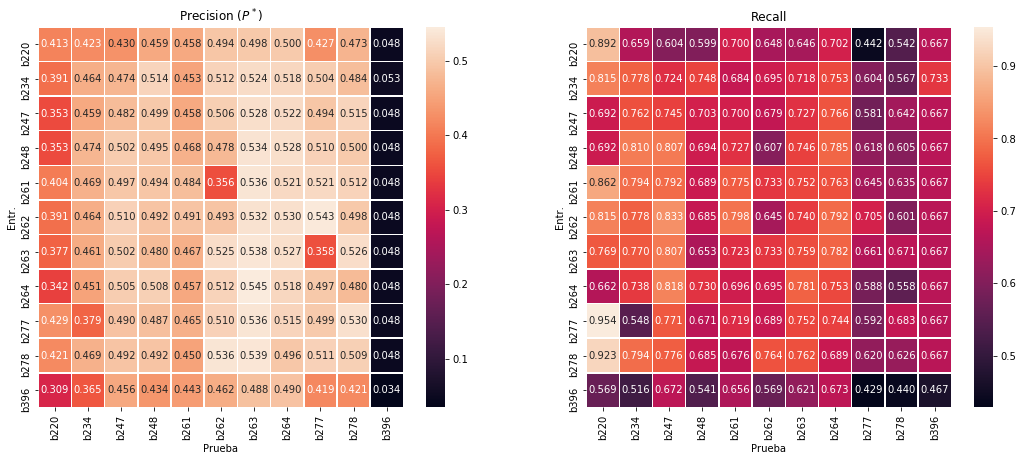

In [94]:
fig, aax = plt.subplots(1, 2, figsize=(18, 7))

def draw(ax, df, suffix):
    prec = df.swaplevel(0, 1, axis=1)[["prec"]]
    sns.heatmap(prec, annot=True, fmt='.3f',  linewidths=.5, ax=ax[0]);
    
    recall = df.swaplevel(0, 1, axis=1)[["rec"]]
    sns.heatmap(recall, annot=True, fmt='.3f', linewidths=.5, ax=ax[1]);

    labels = [l.get_text().split("-", 1)[-1] for l in ax[0].get_xticklabels()]
    ax[0].set_xticklabels(labels)
    ax[1].set_xticklabels(labels)

    ax[0].set_title(u"Precision ($P^*$)")
    ax[1].set_title(u"Recall")

    ax[0].set_xlabel("Prueba")
    ax[1].set_xlabel("Prueba")
    return prec, recall

prec, rec = draw(ax=aax, df=raw.loc["Peq"], suffix=u"Pequeña")

plt.savefig("workpoint2.pdf")
plt.show()

In [95]:
prec.columns = prec.columns.levels[1]
prec = prec.drop(["b396"], axis=1).drop(["b396"], axis=0)
prec

,b220,b234,b247,b248,b261,b262,b263,b264,b277,b278
Entr.,,,,,,,,,,
b220,0.412540,0.422913,0.429672,0.458920,0.458499,0.494486,0.497879,0.500261,0.426987,0.472554
b234,0.390877,0.463888,0.474445,0.514233,0.452830,0.512055,0.524322,0.517882,0.504174,0.483782
b247,0.352685,0.458764,0.481524,0.498704,0.458499,0.506336,0.527567,0.522094,0.494445,0.514768
b248,0.352685,0.473850,0.501661,0.495478,0.468143,0.478203,0.533926,0.528277,0.509833,0.500223
b261,0.404062,0.468916,0.496775,0.493850,0.483900,0.356166,0.536008,0.521048,0.520773,0.512106
b262,0.390877,0.463888,0.509597,0.492211,0.491434,0.493270,0.531825,0.530303,0.542879,0.498343
b263,0.377095,0.461338,0.501661,0.480433,0.466787,0.525255,0.538071,0.527258,0.357711,0.525977
b264,0.342377,0.450892,0.504866,0.508138,0.457093,0.512055,0.545150,0.517882,0.497404,0.479755
b277,0.428791,0.378584,0.490109,0.487229,0.465423,0.509783,0.536008,0.514673,0.499357,0.530152


In [96]:
rec.columns = rec.columns.levels[1]
rec = rec.drop(["b396"], axis=1).drop(["b396"], axis=0)
rec

,b220,b234,b247,b248,b261,b262,b263,b264,b277,b278
Entr.,,,,,,,,,,
b220,0.892308,0.658730,0.604167,0.599099,0.699605,0.647799,0.645768,0.701923,0.442396,0.541950
b234,0.815385,0.777778,0.723958,0.747748,0.683794,0.694969,0.717868,0.753205,0.603687,0.566893
b247,0.692308,0.761905,0.744792,0.702703,0.699605,0.679245,0.727273,0.766026,0.580645,0.641723
b248,0.692308,0.809524,0.807292,0.693694,0.727273,0.606918,0.746082,0.785256,0.617512,0.605442
b261,0.861538,0.793651,0.791667,0.689189,0.774704,0.732704,0.752351,0.762821,0.645161,0.634921
b262,0.815385,0.777778,0.833333,0.684685,0.798419,0.644654,0.739812,0.791667,0.705069,0.600907
b263,0.769231,0.769841,0.807292,0.653153,0.723320,0.732704,0.758621,0.782051,0.661290,0.671202
b264,0.661538,0.738095,0.817708,0.729730,0.695652,0.694969,0.780564,0.753205,0.587558,0.557823
b277,0.953846,0.547619,0.770833,0.671171,0.719368,0.688679,0.752351,0.743590,0.592166,0.682540


In [101]:
print "PREC", prec.values.mean()
print "RECALL", rec.values.mean()

PREC 0.48139790644
RECALL 0.712186971408
